<a href="https://colab.research.google.com/github/azdfkpot/NNs-and-ODEs/blob/main/Laplac_pinn7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Physics Informed Neural Network (PINNs) for the Laplace equation**

Let's the Laplace equation in two dimensions given by:
$$\frac{\partial^2T}{\partial x^2}+\frac{\partial^2T}{\partial y^2}=0$$
in the following domain:
$$
\mathcal{D}=\{(x, y)|\hspace{0.1cm}  1\leq x \leq -1,\hspace{0.1cm} 1\leq y \leq -1\},
$$
with the BCs:
$$ T(-1,y)=75º,  $$
$$ T(1,y)=0º,  $$
$$ T(x,-1)=50º,  $$
$$ T(x,1)=0º. $$

### **Methodology**

The method constructs a neural network approximation

$$
T_\theta(x,y) \approx T(x,y)
$$

of the solution of the PDE, where $T_\theta : \mathcal{D} \to \mathbb{R}$ denotes a function realized by a neural network with parameters $\theta$.

The approach is based on the (strong) residual of a given neural network approximation $T_\theta : \mathcal{D} \to \mathbb{R}$ of the solution $T$, i.e.,

$$
\begin{align}
    r_\theta (x,y) := \frac{\partial^2T_\theta}{\partial x^2}+\frac{\partial^2T_\theta}{\partial y^2}.
\end{align}
$$

To incorporate this PDE residual $r_\theta$ into a loss function to be minimized, PINNs require a further differentiation to evaluate the differential operators $\partial_x^2T_\theta$ and $\partial_y^2T_\theta$.
Thus the PINN term $r_\theta$ shares the same parameters as the original network $T_\theta(x,y)$, but respects the underlying "physics" of the nonlinear PDE.
The derivatives can be easily determined through automatic differentiation with current state-of-the-art machine learning libraries, e.g., TensorFlow or PyTorch.

The PINN approach for the solution of the boundary value problem now proceeds by minimization of the loss functional

$$
\begin{align}
    L_\theta(X) := L_\theta^r(X^r)  + L_\theta^b(X^b),
\end{align}
$$

where $X$ denotes the collection of training data and the loss function $L_\theta$ contains the following terms:

  - the mean squared residual
$$
  \begin{align*}
   L_\theta^r(X^r) := \frac{1}{N_r}\sum_{i=1}^{N_r} \left|r_\theta\left(x_i^r, y_i^r\right)\right|^2
\end{align*}
$$
in a number of collocation points $X^r:=\{(x_i^r, y_i^r)\}_{i=1}^{N_r} \subset  \mathcal{D}$, where $r_\theta$ is the physics-informed neural network,
  - the mean squared misfit with respect to the boundary conditions
$$
    \begin{align*}
   L_\theta^b(X^b)
   :=
   \frac{1}{N_b}
   \sum_{i=1}^{N_b} \left|T_\theta\left(x_i^b, y_i^b\right) - T\left(x_i^b, y_i^b\right)\right|^2
    \end{align*}
$$
in a number of points $X^b:=\{(x^b_i,y^b_i)\}_{i=1}^{N_b} \subset \mathcal{\partial D}$, where $T_\theta$ is the neural network approximation of the solution $T\colon \mathcal{D} \to \mathbb{R}$.

Note that the training data $X$ consists entirely of space coordinates.




# 1.   Import necessary packages and set problem specific data





In [2]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc

In [3]:
tf.keras.backend.set_floatx("float64")



## 2.   Generate a set of boundary and collocation points





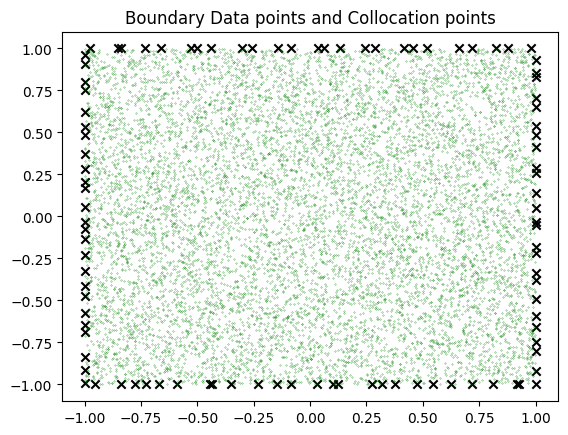

In [4]:
n_bc = 4
n_data_per_bc = 25
#
engine = qmc.LatinHypercube(d=1)
data = np.zeros([4, 25, 3])

for i, j in zip(range(n_bc), [-1, +1, -1, +1]):
    points = (engine.random(n=n_data_per_bc)[:, 0] - 0.5) * 2
    if i < 2:
        data[i, :, 0] = j
        data[i, :, 1] = points
    else:
        data[i, :, 0] = points
        data[i, :, 1] = j

# BC Values
# normalized in [0, 1]
data[0, :, 2] = 1.
data[2, :, 2] = 50/75

data = data.reshape(n_data_per_bc * n_bc, 3)
#
x_d, y_d, t_d = map(lambda x: np.expand_dims(x, axis=1),
                    [data[:, 0], data[:, 1], data[:, 2]])

#

Nc = 10000
engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = 2 * (colloc -0.5)
#
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1),
               [colloc[:, 0], colloc[:, 1]])

#

plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=.2, marker=".", c="g", label="CP")
plt.show()

#

x_c, y_c, x_d, y_d, t_d =map(lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
                             [x_c, y_c, x_d, y_d, t_d])


### 3. Set up network architecture

In this example, we assume a feedforward neural network of the following structure:
- the input layer has two features $x$ and $y$,
- followed by 10 fully connected layers each containing 20 neurons and each followed by a hyperbolic tangent activation function,
- one fully connected output layer.

This setting results in a network with $3441$ trainable parameters (first hidden layer: $2 \cdot 20 + 20 = 60$; seven intermediate layers: each $20 \cdot 20 + 20 = 420$; output layer: $20 \cdot 1 + 1 = 21$).

In [5]:
### model builder function
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=10,
                neuron_per_layer=20, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

Model: "DNN-9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                420   

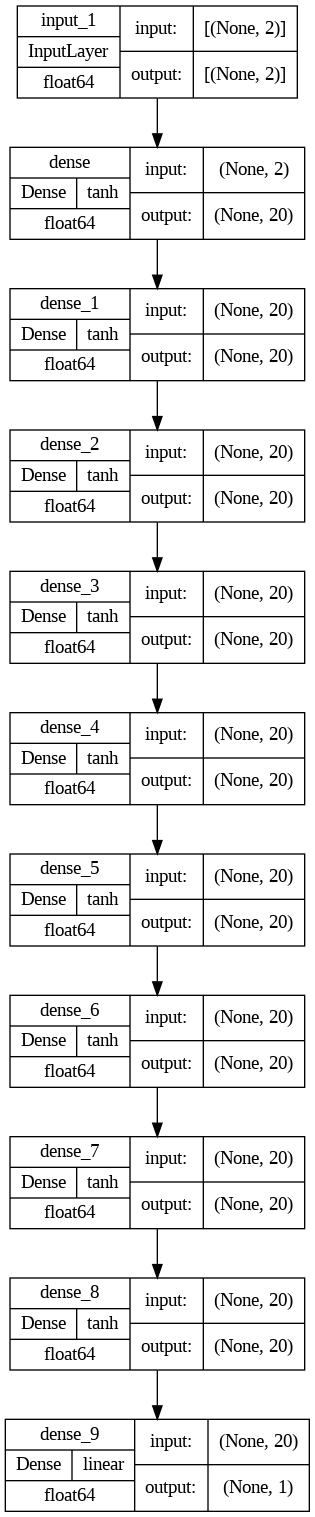

In [6]:
tf.keras.backend.clear_session()
model = DNN_builder(2, 1, 9, 20, "tanh")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True,
                          show_layer_names=True, show_dtype=True,
                          show_layer_activations=True)

### 4. Define routines to determine loss and gradient

In the following code cell, we define a function which evaluates the residual

$$
\begin{align}
    r_\theta (x,y) := \frac{\partial^2T_\theta}{\partial x^2}+\frac{\partial^2T_\theta}{\partial y^2}.
\end{align}
$$

of the Laplace PDE in the points $X_r = \{(x^r_i,y^r_i)\}_{i=1}^{N_r}$.
To compute the necessary partial derivatives we use the automatic differentiation capabilities of TensorFlow.

For the Laplace equation, this entails computing $\partial^2_x T_\theta$ and $\partial^2_y T_\theta$.
In TensorFlow, this is done via a `GradientTape`.

In [7]:
@tf.function
def u(x, y):
    u = model(tf.concat([x, y], axis=1))
    return u

In [8]:
@tf.function
def f(x, y):
    u0 = u(x, y)
    u_x = tf.gradients(u0, x)[0]
    u_y = tf.gradients(u0, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    F = u_xx + u_yy
    return tf.reduce_mean(tf.square(F))

In [9]:
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

    0, 4.508
  200, 0.064
  400, 0.042
  600, 0.037
  800, 0.030
  999, 0.023

computation time: 289.745



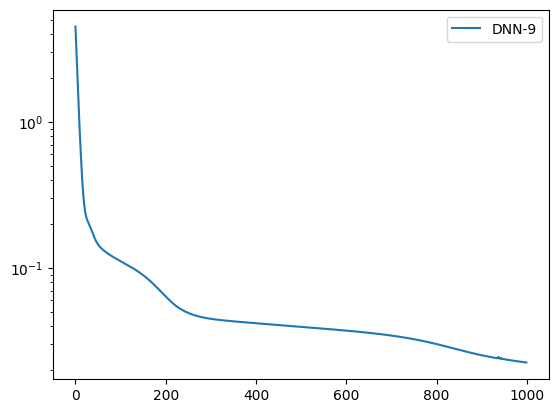

In [10]:
loss = 0
epochs = 1000
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
epoch = 0
loss_values = np.array([])
#
start = time.time()
#
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_ = u(x_d, y_d)
        L = f(x_c, y_c)
        l = mse(t_d, T_)
        loss = l+L
    g = tape.gradient(loss, model.trainable_weights)
    opt.apply_gradients(zip(g, model.trainable_weights))
    loss_values = np.append(loss_values, loss)
    if epoch % 200 == 0 or epoch == epochs-1:
        print(f"{epoch:5}, {loss.numpy():.3f}")

#
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")
#
plt.semilogy(loss_values, label=model.name)
plt.legend()

In [13]:
n = 100
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])

bc = {
    "x=-l": 75.,
    "x=+l": 0.,
    "y=-l": 50.,
    "y=+l": 0.
}

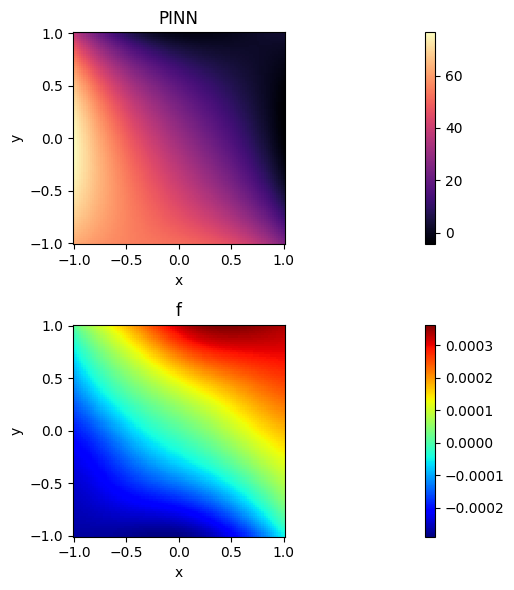

In [21]:
### plotting
plt.figure("", figsize=(12, 6))
#
X = np.linspace(-1, +1, n)
Y = np.linspace(-1, +1, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)
S = u(X_T, Y_T)
S = S.numpy().reshape(n, n)
#
plt.subplot(221)
plt.pcolormesh(X0, Y0, 75.*S, cmap="magma")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN")
plt.tight_layout()
plt.axis("square")
#
x = np.linspace(-1, +1, n)
y = np.linspace(-1, +1, n)
x, y = np.meshgrid(x, y)
#

#
plt.subplot(223)
pinn_grad = np.gradient(np.gradient(S, axis=0), axis=1)
sigma_pinn = (pinn_grad**2).mean()
plt.pcolormesh(X0, Y0, pinn_grad, cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("f")
plt.tight_layout()
plt.axis("square")
###
x = np.linspace(-1, +1, n)
y = np.linspace(-1, +1, n)
x, y = np.meshgrid(x, y)
#

plt.show()